In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt


# Set random seed
seed = 0



In [2]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [3]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8784 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               8784 non-null   object 
 13  video                 8784 non-null   int64  
 14  vote_average          8784 non-null   float64
 15  vote_count           

# Scoring prediction

In [4]:
df['video'].value_counts()

video
0    8778
1       6
Name: count, dtype: int64

In [5]:
# Get list of all unique names in df[`cast`]
df['cast'] = df['cast'].replace(np.nan, '')
unique_cast = df['cast'].str.split(',').explode()
unique_cast.value_counts()
# Take only actors that appeared in more than 10 movies
top_cast = unique_cast.value_counts()[unique_cast.value_counts() > 10]

df['cast'] = df['cast'].apply(lambda x: [i for i in x.split(',') if i in top_cast.index]).apply(lambda x: ','.join(x))
df['production_companies'] = df['production_companies'].replace(np.nan, '')
unique_production_companies = df['production_companies'].str.split(',').explode()
unique_production_companies.value_counts()

top_companies = unique_production_companies.value_counts()[unique_production_companies.value_counts() > 10]
df['production_companies'] = df['production_companies'].apply(lambda x: [i for i in x.split(',') if i in top_companies.index]).apply(lambda x: ','.join(x))
df['directors'] = df['directors'].replace(np.nan, '')
unique_directors = df['directors'].str.split(',').explode()
unique_directors.value_counts()

top_directors = unique_directors.value_counts()[unique_directors.value_counts() > 10]
df['directors'] = df['directors'].apply(lambda x: [i for i in x.split(',') if i in top_directors.index]).apply(lambda x: ','.join(x))
df['production_countries'] = df['production_countries'].replace(np.nan, '')
df['spoken_languages'] = df['spoken_languages'].replace(np.nan, '')
df['genres'] = df['genres'].replace(np.nan, '')
df['tagline'] = df['tagline'].replace(np.nan, '')
df['overview'] = df['overview'].replace(np.nan, '')

In [6]:
X = df.drop(columns=['vote_average', 'category'])
X = df.drop(columns=['video', 'adult', 'release_day'])
Y = df['category']


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


# Feature encoding

In [8]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                8784 non-null   int64  
 1   genres                8784 non-null   object 
 2   original_language     8784 non-null   object 
 3   overview              8784 non-null   object 
 4   popularity            8784 non-null   float64
 5   production_companies  8784 non-null   object 
 6   production_countries  8784 non-null   object 
 7   revenue               8784 non-null   int64  
 8   runtime               8784 non-null   float64
 9   spoken_languages      8784 non-null   object 
 10  status                8784 non-null   object 
 11  tagline               8784 non-null   object 
 12  vote_average          8784 non-null   float64
 13  vote_count            8784 non-null   float64
 14  cast                  8784 non-null   object 
 15  directors            

In [9]:
print(X.head())

      budget                                         genres original_language  \
0  200000000      Adventure,Action,Thriller,Science Fiction                en   
1  130000000               Science Fiction,Action,Adventure                en   
2  165000000               Action,Adventure,Science Fiction                en   
3  120000000               Action,Adventure,Science Fiction                en   
4   78000000  Fantasy,Action,Crime,Science Fiction,Thriller                en   

                                            overview  popularity  \
0  For centuries, a small but powerful force of w...      31.264   
1  One thousand years after cataclysmic events fo...      29.537   
2  We always knew they were coming back. Using re...      33.521   
3  Four young outsiders teleport to a dangerous u...      24.238   
4  He dwells in a world of eternal night, but the...      23.563   

                                production_companies  \
0  DC Entertainment,De Line Pictures,Warner Bros

In [10]:

numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline', 'title']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        # ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', text_transformer, 'genres'),
        ('production_companies', text_transformer, 'production_companies'),
        ('production_countries', text_transformer, 'production_countries'),
        ('cast', text_transformer, 'cast'),
        ('directors', text_transformer, 'directors')
    ]
)

In [11]:
X_train_encoded = preprocessor.fit_transform(X_train)
print(X_train_encoded)

X_test_encoded = preprocessor.transform(X_test)  #Just transform, not fit so they have the same number of features
print(X_test_encoded)

  (0, 0)	-0.08619960335899651
  (0, 1)	-0.18237344551555748
  (0, 2)	0.08345800497584235
  (0, 3)	-0.5505827317471977
  (0, 4)	1.795802171379134
  (0, 5)	0.42331317103209676
  (0, 6)	1.2175666622553376
  (0, 15)	1.0
  (0, 42)	1.0
  (0, 116)	0.5864674656785438
  (0, 124)	0.5226236148284815
  (0, 130)	0.6188056794537337
  (0, 198)	1.0
  (0, 244)	0.6937175157199655
  (0, 249)	0.46303948736614914
  (0, 260)	0.5516796548025068
  (0, 273)	0.28120239791970725
  (0, 299)	0.43938915948487495
  (0, 302)	0.29381623162362774
  (0, 329)	0.440833707193948
  (0, 331)	0.33524861148923174
  (0, 333)	0.2608753051066312
  (0, 343)	0.4338761288913083
  (0, 360)	0.28018563672299496
  (0, 367)	0.302264718805644
  :	:
  (7025, 452)	0.2912134271980113
  (7025, 461)	0.27482428700138295
  (7026, 0)	0.1793668052887353
  (7026, 1)	-0.1509840149906671
  (7026, 2)	-0.12953782644463857
  (7026, 3)	-1.1135691250570259
  (7026, 4)	-0.07500471776376888
  (7026, 5)	0.4843423180098479
  (7026, 6)	0.34449197240177887
  (7

In [12]:
print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")


X_train_encoded shape: (7027, 664)
X_test_encoded shape: (1757, 664)


# Transparent Models

## Decision Tree

### CART Algorithm

In [13]:
cart_tree = DecisionTreeClassifier(random_state=seed)

In [14]:
cart_tree.fit(X_train_encoded, Y_train_encoded)

DecisionTreeClassifier(random_state=0)

In [15]:
Y_pred = cart_tree.predict(X_test_encoded)

In [16]:

accuracy = accuracy_score(Y_test_encoded, Y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6323


In [17]:
print(classification_report(Y_test_encoded, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       450
           1       0.49      0.54      0.52       430
           2       0.66      0.63      0.65       429
           3       0.55      0.56      0.56       448

    accuracy                           0.63      1757
   macro avg       0.64      0.63      0.63      1757
weighted avg       0.64      0.63      0.64      1757



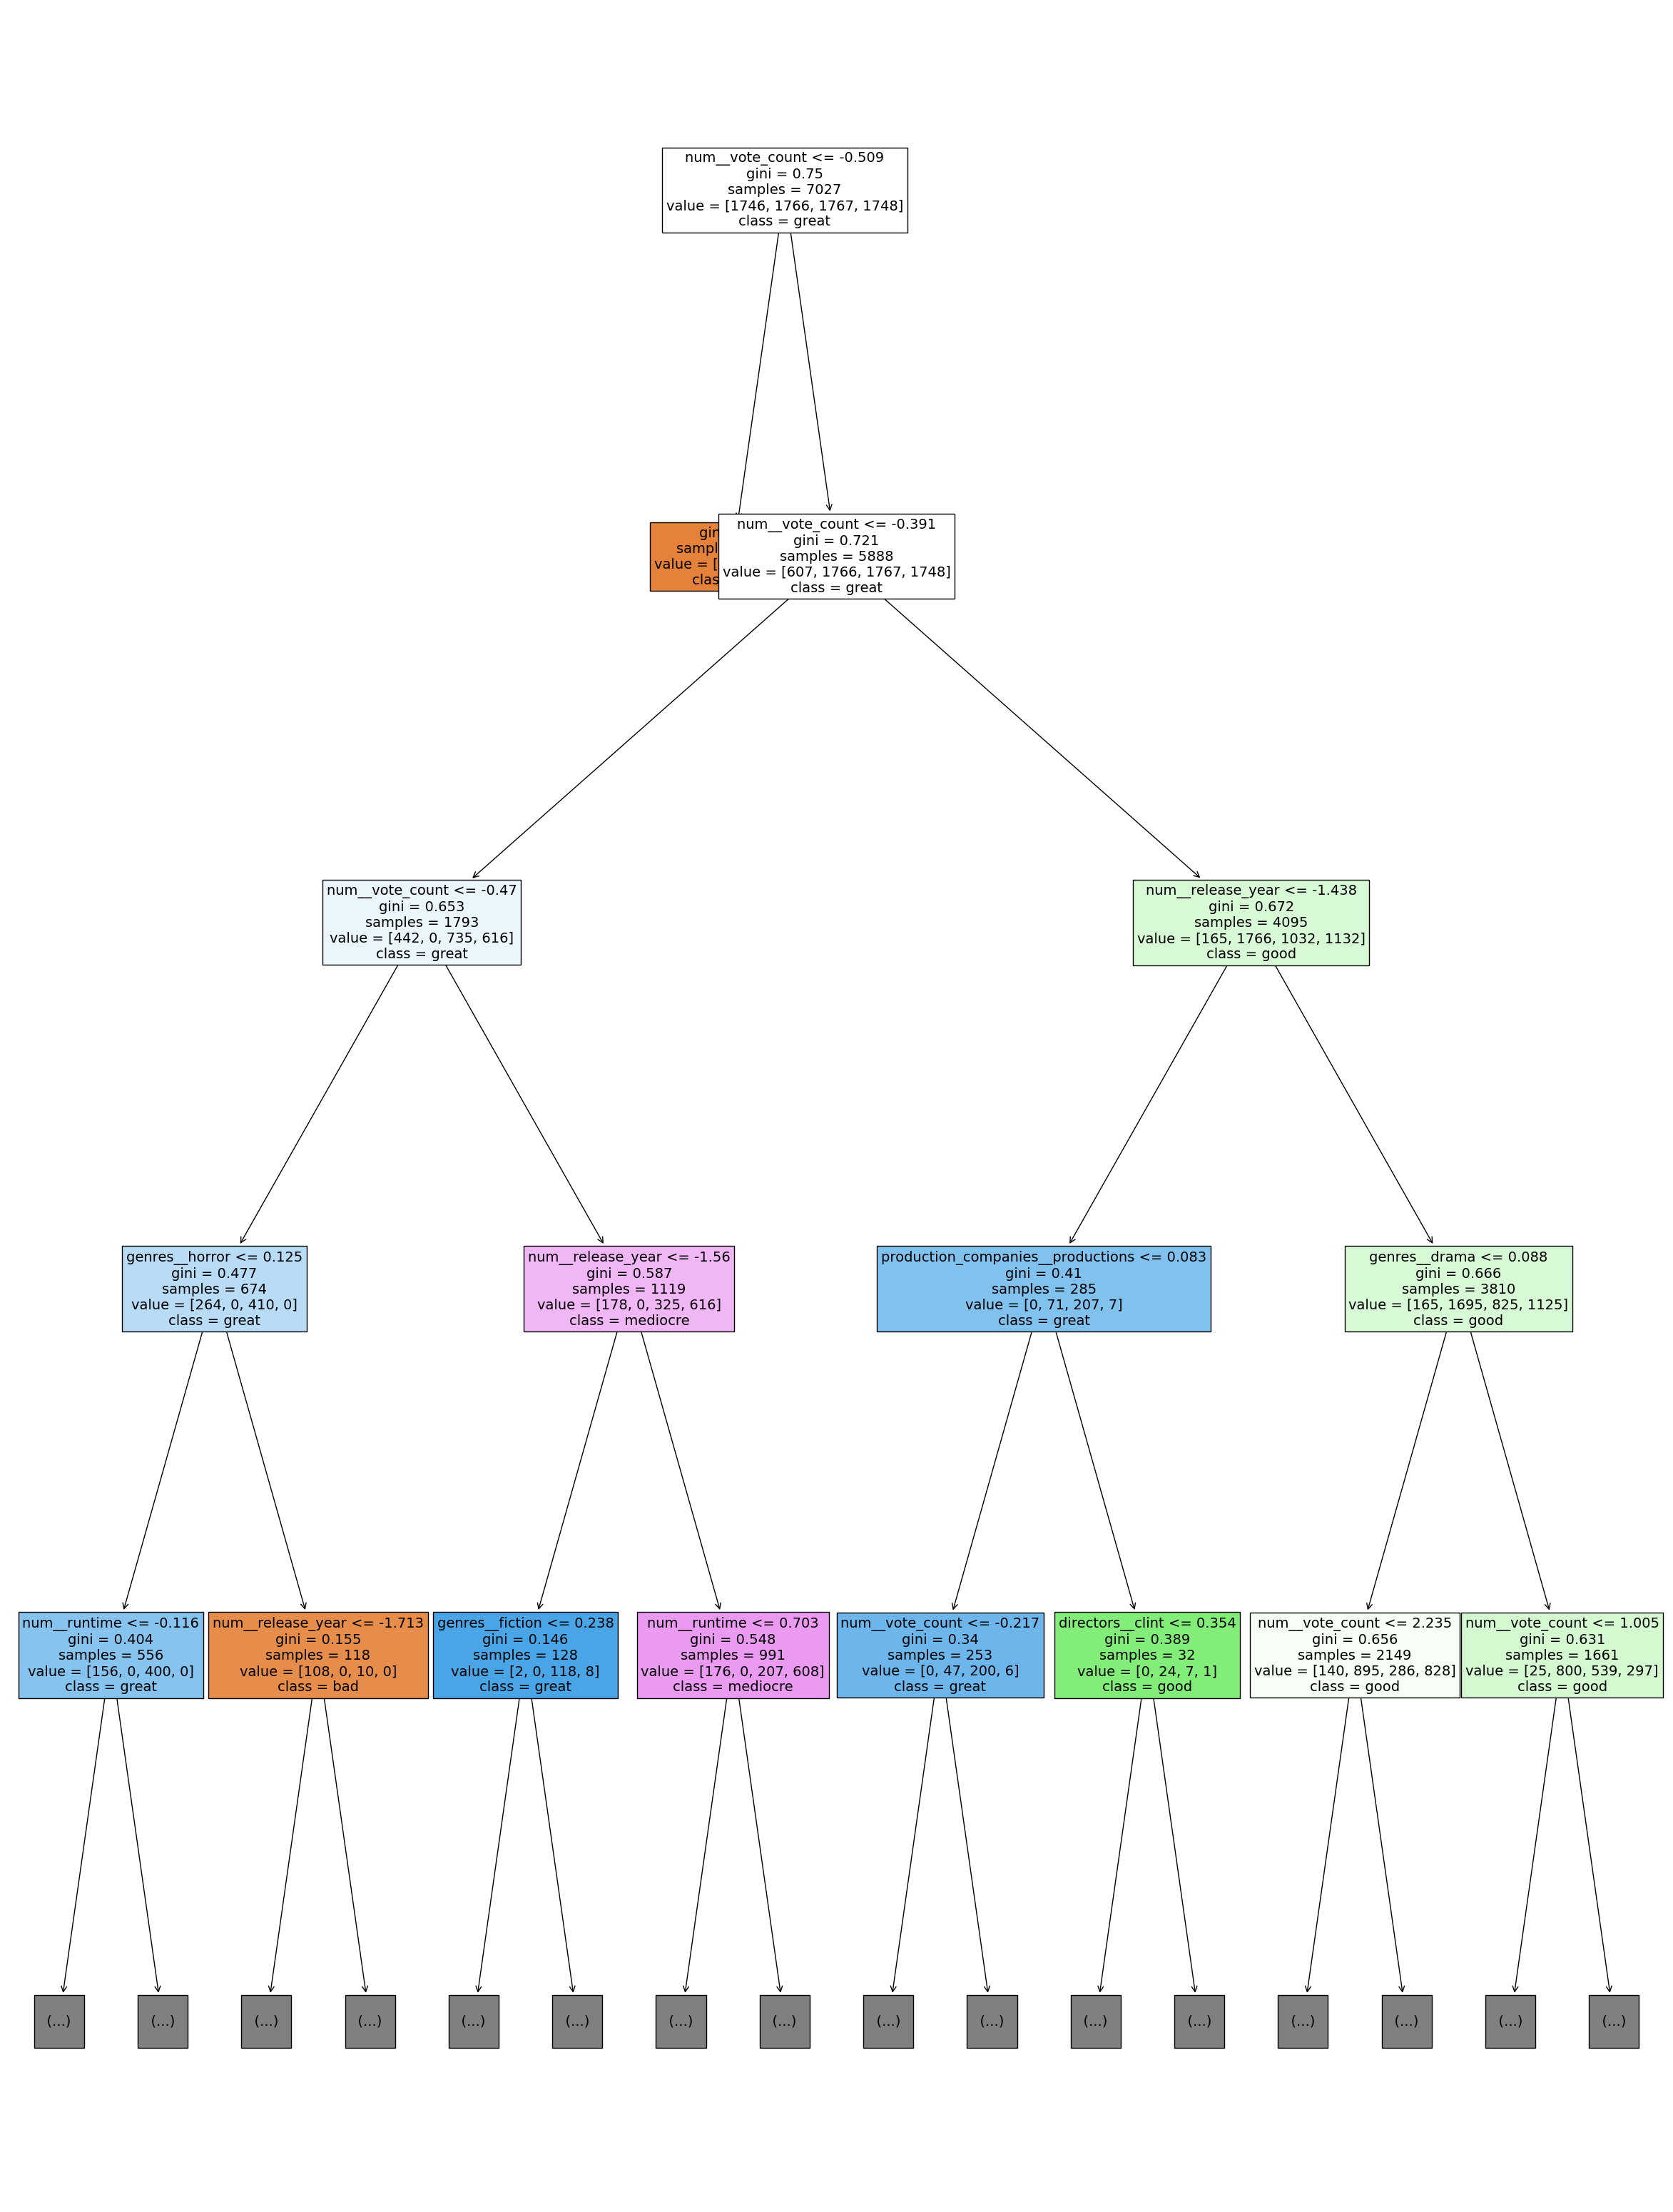

In [18]:
# Visualizing the decision tree with bigger rectangles and text
plt.figure(figsize=(30, 40)) 
plot_tree(cart_tree, 
          filled=True, 
          feature_names=preprocessor.get_feature_names_out(), 
          class_names=label_encoder.classes_, 
          max_depth=4, 
          fontsize=14)  
plt.show()


In [19]:
# Writing the decision tree rules as text
tree_rules = export_text(cart_tree, feature_names=list(preprocessor.get_feature_names_out()))
print(tree_rules)



|--- num__vote_count <= -0.51
|   |--- class: 0
|--- num__vote_count >  -0.51
|   |--- num__vote_count <= -0.39
|   |   |--- num__vote_count <= -0.47
|   |   |   |--- genres__horror <= 0.12
|   |   |   |   |--- num__runtime <= -0.12
|   |   |   |   |   |--- num__release_year <= -0.77
|   |   |   |   |   |   |--- num__popularity <= -0.21
|   |   |   |   |   |   |   |--- overview__boy <= 0.56
|   |   |   |   |   |   |   |   |--- overview__college <= 0.52
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- overview__college >  0.52
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- overview__boy >  0.56
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- num__popularity >  -0.21
|   |   |   |   |   |   |   |--- num__vote_count <= -0.49
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- num__vote_count >  -0.49
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |

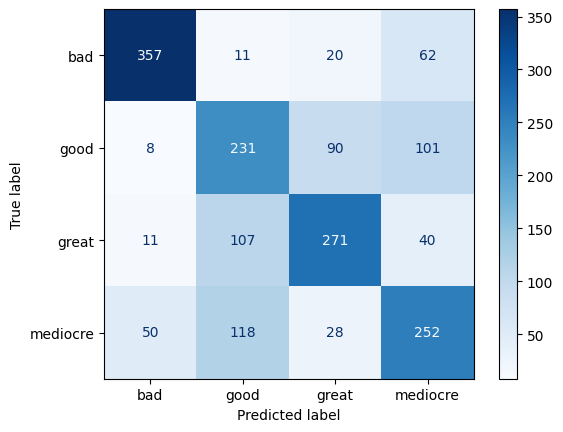

In [20]:
# Confusion matrix
cm = confusion_matrix(Y_test_encoded, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


#### Wrappers to  tune parameters

#### RandomizedSearchCV

In [282]:
from sklearn.model_selection import RandomizedSearchCV

new_cart_tree = DecisionTreeClassifier(random_state=seed)


param_grid = {
    'criterion': ['gini', 'entropy'],  # Split quality
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
}

random_search = RandomizedSearchCV(estimator=new_cart_tree, 
                                   param_distributions=param_grid, 
                                   n_iter=500, 
                                   scoring='accuracy',
                                   cv=5, 
                                   verbose=1, 
                                   random_state=seed,
                                   n_jobs=-1)


random_search.fit(X_train_encoded, Y_train_encoded)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

#Output: 
#Fitting 5 folds for each of 432 candidates, totalling 2160 fits, 720 fits failed out of a total of 2160.
#Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'entropy'}
#Best Cross-Validation Score: 0.543764041246716


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 432 is smaller than n_iter=500. Running 432 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.543764041246716


C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\

In [283]:
# Best parameters from RandomizedSearchCV wrapper output
best_params = {
    'criterion': 'entropy',
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2
}

new_cart_tree = DecisionTreeClassifier(random_state=seed, **best_params)

new_cart_tree.fit(X_train_encoded, Y_train_encoded)

Y_pred_new = new_cart_tree.predict(X_test_encoded)

In [284]:

accuracy = accuracy_score(Y_test_encoded, Y_pred_new)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5282


In [285]:
print(classification_report(Y_test_encoded, Y_pred_new))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       450
           1       0.41      0.46      0.44       430
           2       0.58      0.49      0.53       429
           3       0.43      0.45      0.44       448

    accuracy                           0.53      1757
   macro avg       0.53      0.53      0.53      1757
weighted avg       0.53      0.53      0.53      1757



#### GridSearch

In [33]:

param_grid_search = {
    'max_depth': [5, 10, 15, 20, 25, 30, 40, 50, 60, 100, None],    
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.5, 0.8, 1],      
    'min_samples_split': [2, 3, 4, 5, 6, 8, 10, 15, 20],            
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 10],                    
    'criterion': ['gini', 'entropy'],                               
    'splitter': ['best', 'random']                                  
}



In [34]:
grid_search = GridSearchCV(
    estimator=cart_tree, 
    param_grid=param_grid_search, 
    scoring='accuracy', 
    cv=5, 
    verbose=2, 
    n_jobs=-1
)

In [35]:
grid_search.fit(X_train_encoded, Y_train_encoded)

print("Best parameters:", grid_search.best_params_)

#Output:
#~36min
#Fitting 5 folds for each of 19404 candidates, totalling 97020 fits, 13860 fits failed out of a total of 97020.
#Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 15, 'splitter': 'best'}


Fitting 5 folds for each of 19404 candidates, totalling 97020 fits


C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
13860 fits failed out of a total of 97020.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8545 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCa

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 15, 'splitter': 'best'}


In [54]:
best_params = {
    'criterion': 'entropy', 
    'max_depth': 10, 
    'max_features': 0.8, 
    'min_samples_leaf': 5, 
    'min_samples_split': 15, 
    'splitter': 'best'
}

best_cart_model = DecisionTreeClassifier(**best_params, random_state=seed)


best_cart_model.fit(X_train_encoded, Y_train_encoded)
Y_pred_best = best_cart_model.predict(X_test_encoded)

In [55]:
accuracy = accuracy_score(Y_test_encoded, Y_pred_best)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6659


In [56]:
print(classification_report(Y_test_encoded, Y_pred_best))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       450
           1       0.50      0.65      0.56       430
           2       0.72      0.59      0.65       429
           3       0.60      0.65      0.62       448

    accuracy                           0.67      1757
   macro avg       0.69      0.66      0.67      1757
weighted avg       0.70      0.67      0.67      1757



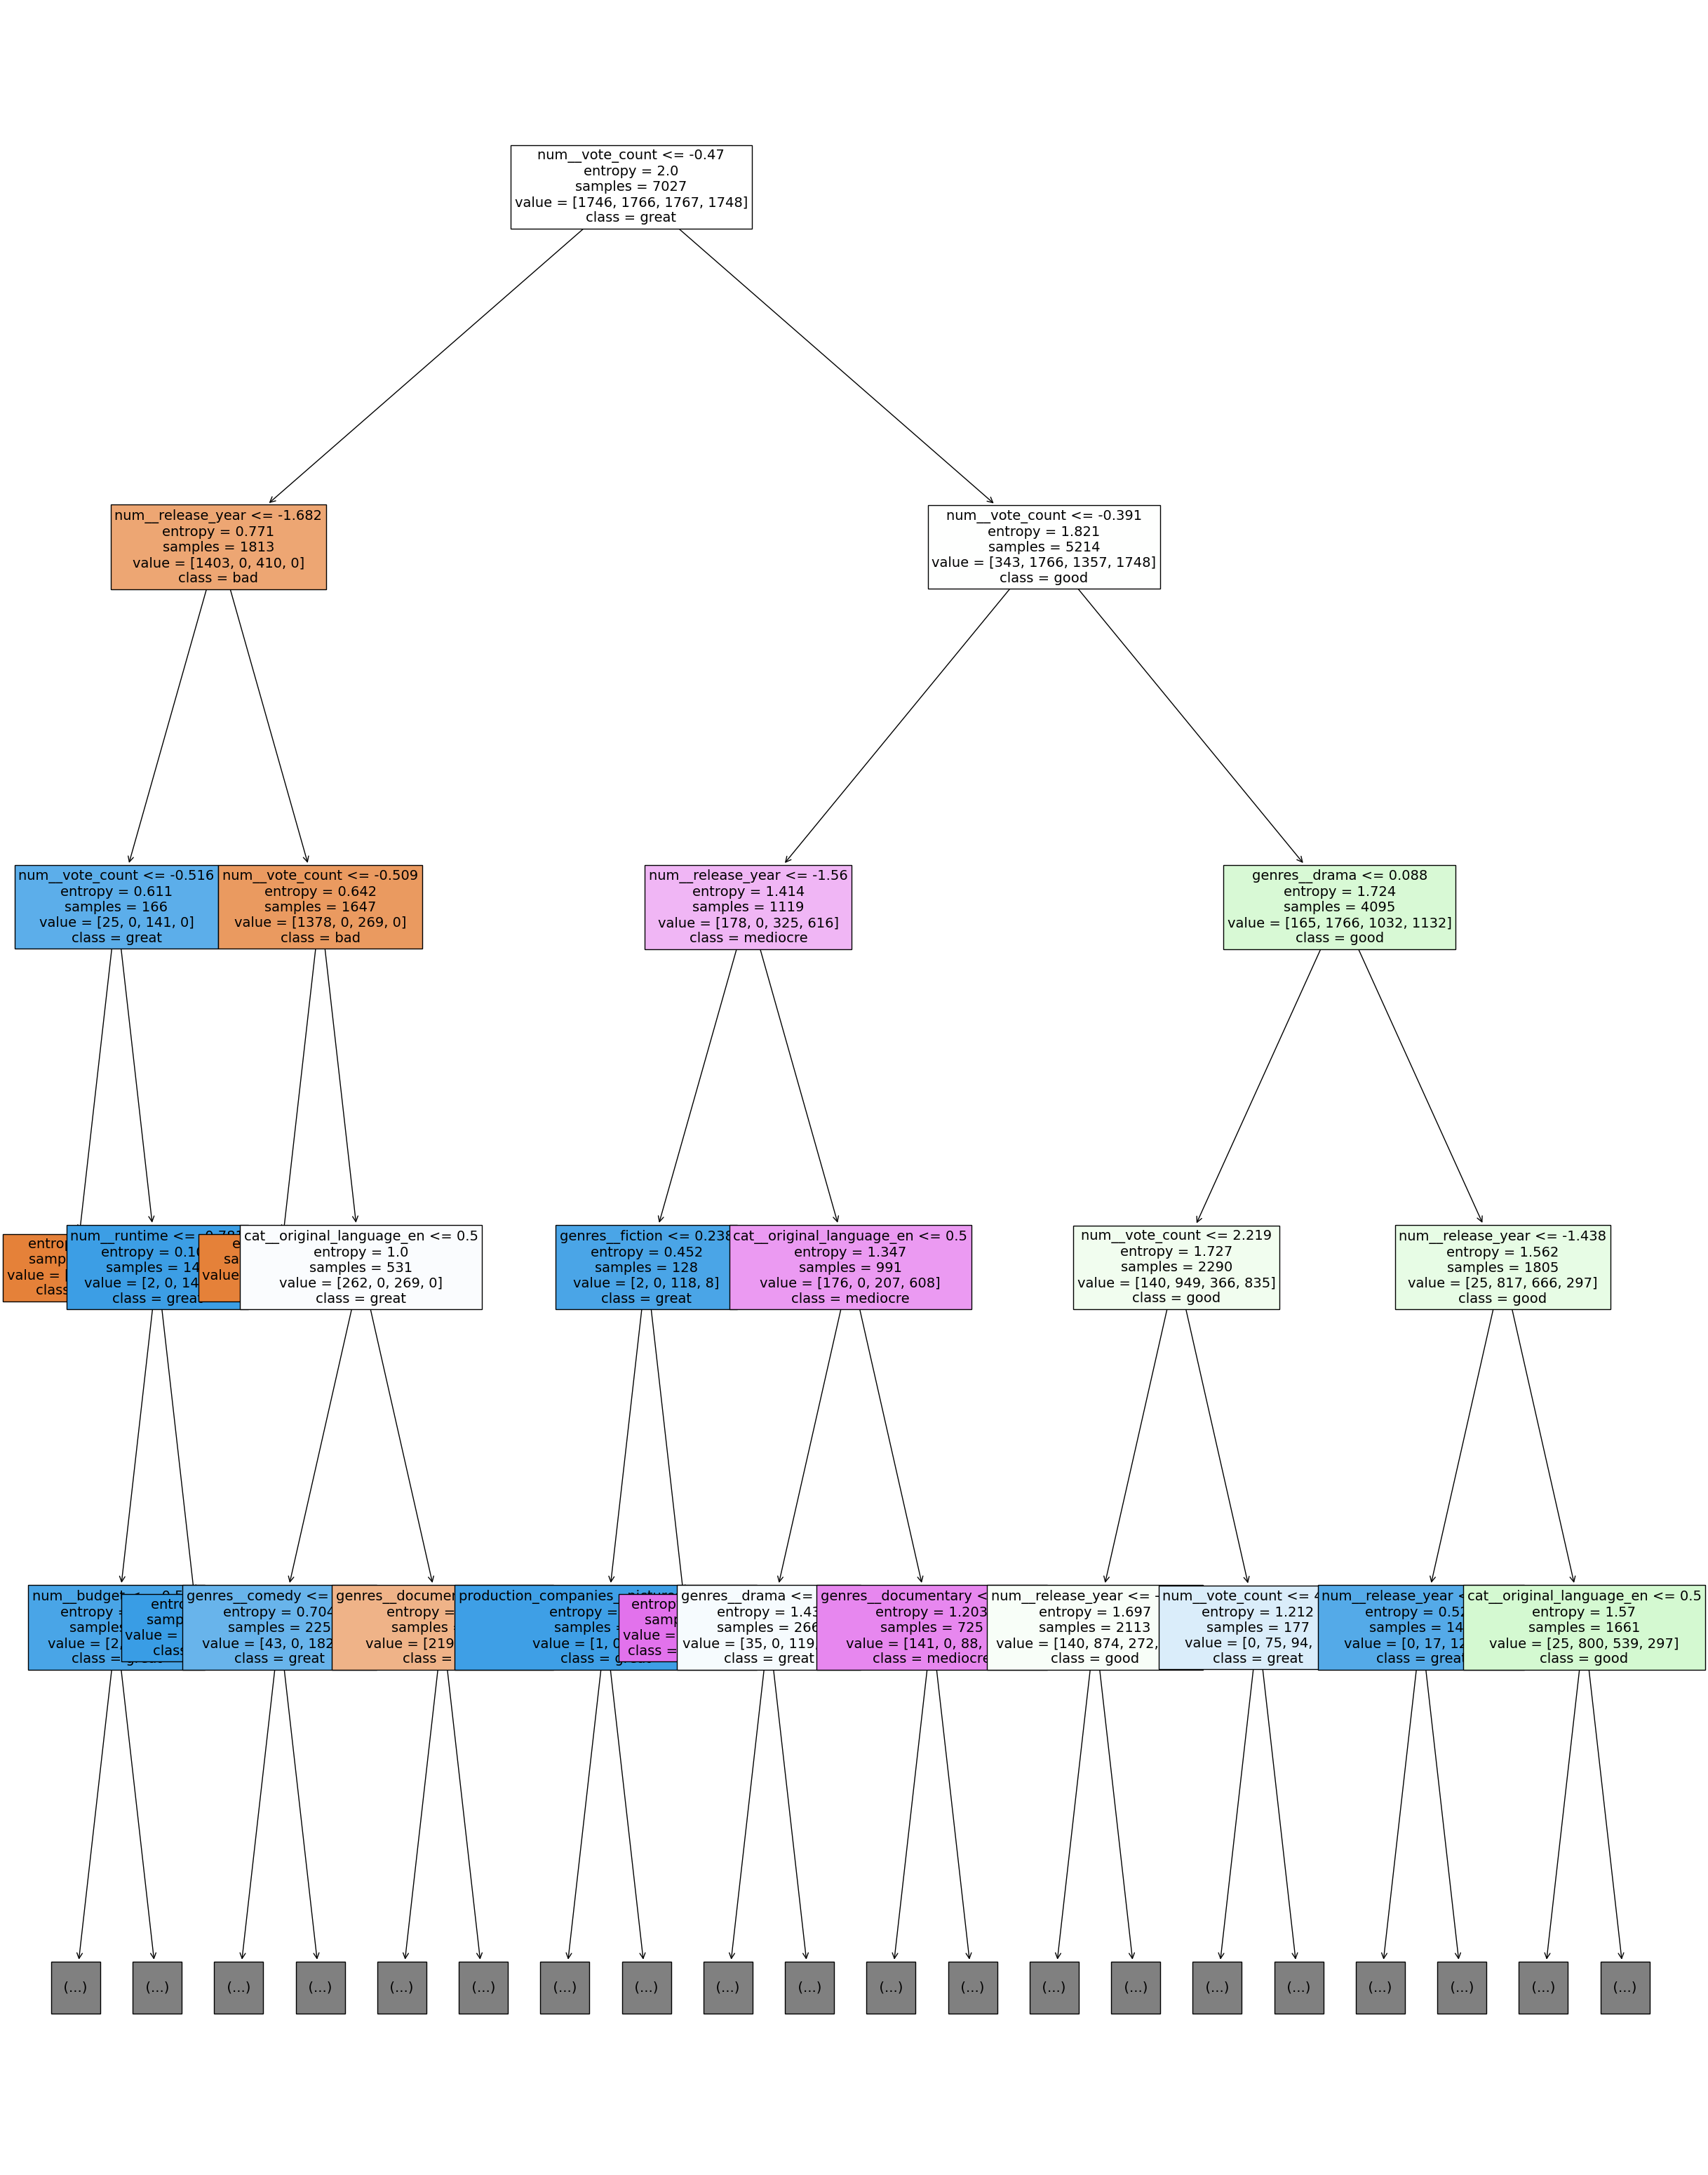

In [62]:
plt.figure(figsize=(30, 40)) 
plot_tree(best_cart_model, 
          filled=True, 
          feature_names=preprocessor.get_feature_names_out(), 
          class_names=label_encoder.classes_, 
          max_depth=4, 
          fontsize=14)  
plt.show()


In [63]:
tree_rules = export_text(best_cart_model, feature_names=list(preprocessor.get_feature_names_out()))
print(tree_rules)

|--- num__vote_count <= -0.47
|   |--- num__release_year <= -1.68
|   |   |--- num__vote_count <= -0.52
|   |   |   |--- class: 0
|   |   |--- num__vote_count >  -0.52
|   |   |   |--- num__runtime <= -0.78
|   |   |   |   |--- num__budget <= -0.56
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- num__budget >  -0.56
|   |   |   |   |   |--- class: 2
|   |   |   |--- num__runtime >  -0.78
|   |   |   |   |--- class: 2
|   |--- num__release_year >  -1.68
|   |   |--- num__vote_count <= -0.51
|   |   |   |--- class: 0
|   |   |--- num__vote_count >  -0.51
|   |   |   |--- cat__original_language_en <= 0.50
|   |   |   |   |--- genres__comedy <= 0.51
|   |   |   |   |   |--- num__runtime <= 0.29
|   |   |   |   |   |   |--- genres__horror <= 0.19
|   |   |   |   |   |   |   |--- num__vote_count <= -0.49
|   |   |   |   |   |   |   |   |--- num__vote_count <= -0.51
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- num__vote_count >  -0.51
|   |   |

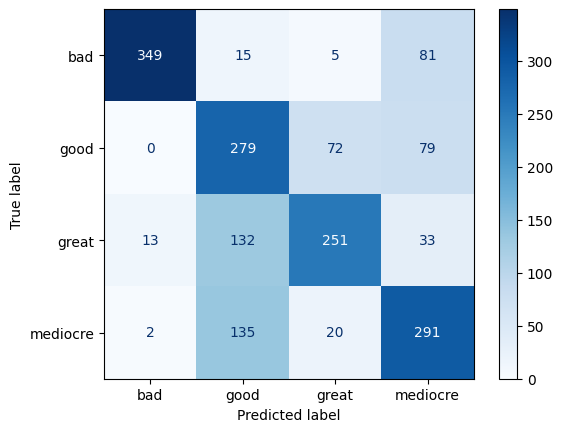

In [64]:
# Confusion matrix
cm = confusion_matrix(Y_test_encoded, Y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
